In [1]:
# ======================================
# 0. Core libs (DAY1~DAY9 공통)
# ======================================
import numpy as np
import pandas as pd

import shutil
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import matplotlib.font_manager as fm
from matplotlib import rcParams

# ======================================
# 1) Style FIRST (폰트보다 먼저)
# ======================================
plt.style.use("_mpl-gallery-nogrid")
sns.set_theme(style="white")
sns.set_style("ticks")
sns.set_context("notebook")

# ======================================
# 2) Font (NanumGothic) — style 적용 후 "고정"
# ======================================
FONT_DIR = Path(r"E:\Portfolio_ver1\seoul_pv_load_analysis\fonts")
FONT_PATH = FONT_DIR / "NanumGothic.ttf"

if not FONT_PATH.exists():
    raise FileNotFoundError(f"폰트 파일 없음: {FONT_PATH}")

fm.fontManager.addfont(str(FONT_PATH))
font_name = fm.FontProperties(fname=str(FONT_PATH)).get_name()

rcParams["font.family"] = font_name
rcParams["axes.unicode_minus"] = False

# (선택) 기본 글자 크기 통일
rcParams["font.size"] = 12
rcParams["axes.titlesize"] = 18
rcParams["axes.labelsize"] = 14
rcParams["xtick.labelsize"] = 12
rcParams["ytick.labelsize"] = 12

# 개별 객체용 (필요할 때만)
font_prop = fm.FontProperties(fname=str(FONT_PATH))

print("✅ Style+Font ready:", font_name)

✅ Style+Font ready: NanumGothic


### DAY 7: 프로젝트 요약 및 결론

**목적**
- 전체 분석 결과를 구조적 관점에서 정리

**주요 작업**
- 핵심 메시지 요약
- 한계 및 확장 가능성 정리

**산출물**
- README 기반 최종 결과 문서

In [2]:
df = pd.read_csv("../data/법정동별시간별전력사용량.csv")

# 예시 전처리 (이미 DAY 1 ~ 6에서 처리했다면 해당 결과 사용)
# df["datetime"] = pd.to_datetime(df["사용일자"].astype(str) + " " + df["사용시간"].astype(str) + ":00")
# df["hour"] = df["datetime"].dt.hour

# USE_HM: 0100, 0200 ... 2300, 2400 형태(HHMM)라고 가정
hm = df["USE_HM"].astype(str).str.zfill(4)

df["hour"] = hm.str[:2].astype(int)

# 2400 같은 값이 있으면 24시로 들어오므로 0시로 정규화
df.loc[df["hour"] == 24, "hour"] = 0

hourly_load = (df.groupby("hour", as_index = False)["FDRCT_VLD_KWH"].mean().rename(columns = {"FDRCT_VLD_KWH": "평균전력사용량"}))
print(sorted(hourly_load["hour"].unique()))
hourly_load.head()


[np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23)]


,hour,평균전력사용량
0,0,5121.083889
1,1,4828.966546
2,2,4436.061656
3,3,4301.931715
4,4,4069.172541


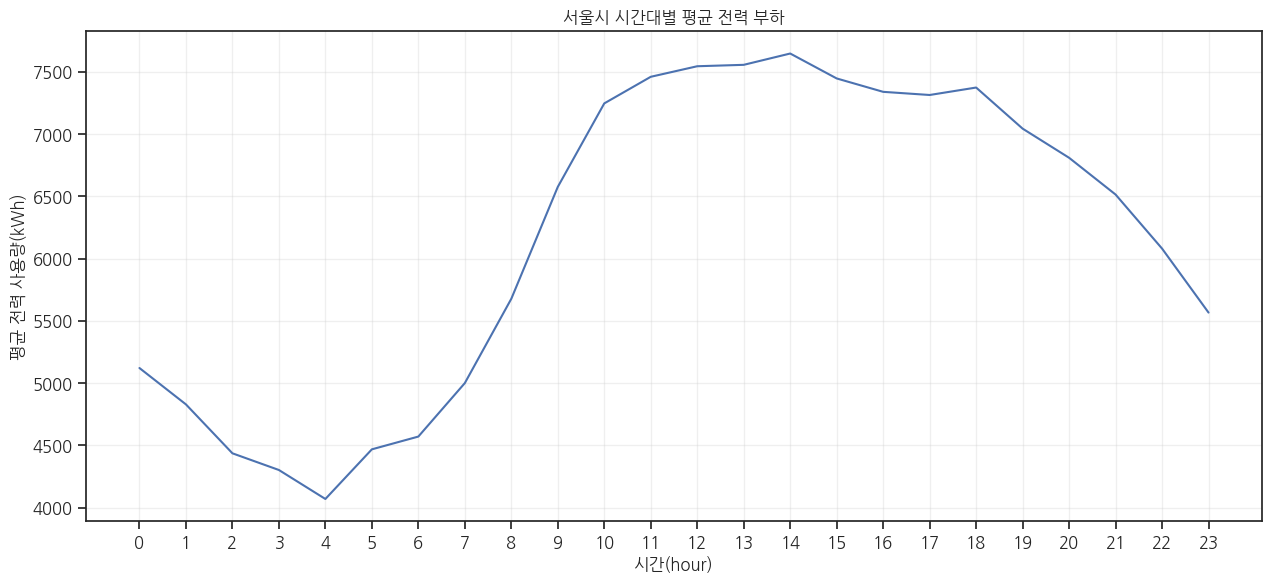

In [3]:
# 대표 그래프 생성
plt.figure(figsize = (12, 5))
plt.plot(hourly_load["hour"], hourly_load["평균전력사용량"])
plt.title("서울시 시간대별 평균 전력 부하", fontproperties = font_prop)
plt.xticks(range(0, 24, 1))
plt.xlabel("시간(hour)", fontproperties = font_prop)
plt.ylabel("평균 전력 사용량(kWh)", fontproperties = font_prop)
plt.grid(alpha = 0.3)
plt.tight_layout
plt.show()

In [4]:
output_dir = Path("outputs")
output_dir.mkdir(exist_ok=True)

hourly_load.to_csv(output_dir / "서울시_시간대별_전력부하.csv", index=False)
print("저장 완료:", output_dir / "서울시_시간대별_전력부하.csv")

저장 완료: outputs\서울시_시간대별_전력부하.csv


In [5]:
hours = np.arange(0, 24)

# 이론적 PV 발전 패턴 (정오 중심)
pv_raw = np.exp(-0.5 * ((hours - 12) / 3) ** 2)

# 부하 스케일에 맞게 정규화 (최대값 기준)
pv_scaled = pv_raw / pv_raw.max() * hourly_load["평균전력사용량"].max()

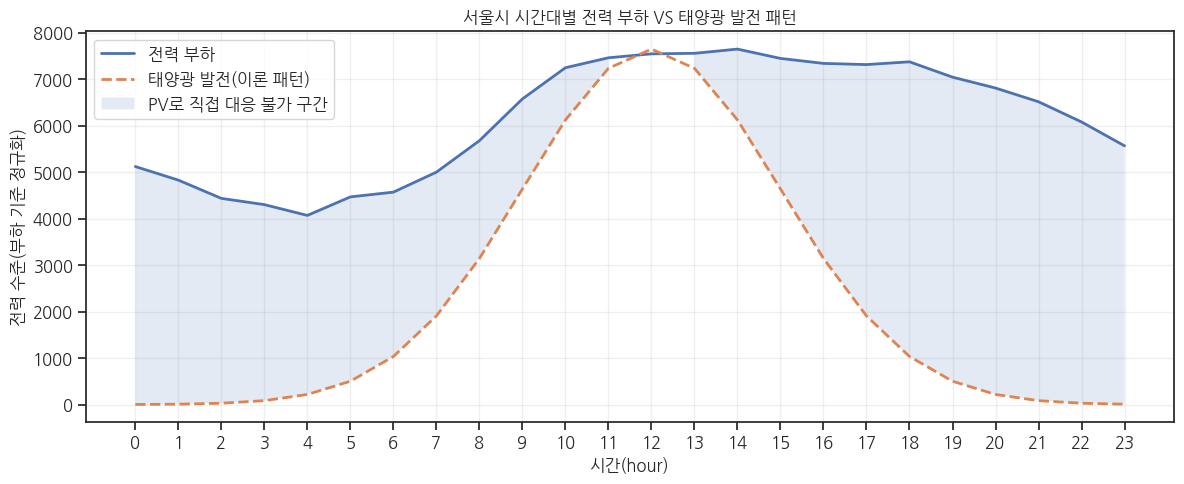

In [6]:
plt.figure(figsize = (12, 5))

# 전력 부하
plt.plot(hourly_load["hour"], hourly_load["평균전력사용량"], label = "전력 부하", linewidth = 2)

# 태양광 (PV) 이론 패턴
plt.plot(hours, pv_scaled, label = "태양광 발전(이론 패턴)", linestyle = "--", linewidth = 2)

plt.title("서울시 시간대별 전력 부하 VS 태양광 발전 패턴", fontproperties = font_prop)
plt.xticks(range(0, 24, 1))
plt.xlabel("시간(hour)", fontproperties = font_prop)
plt.ylabel("전력 수준(부하 기준 정규화)", fontproperties = font_prop)

plt.fill_between(hours, pv_scaled, hourly_load["평균전력사용량"], where = (hourly_load["평균전력사용량"] > pv_scaled), alpha = 0.15, label = "PV로 직접 대응 불가 구간")

plt.legend(prop = font_prop)
plt.grid(alpha = 0.3)
plt.tight_layout()
plt.show()

위의 그래프는 서울시 시간대별 전력 부하와 태양광 발전의
이론적 시간대 패턴을 비교한 결과이다.
실제 발전량이 아닌 패턴 중심 비교를 통해,
전력 수요와 태양광 발전 간 시간대 불일치 구조를 시각적으로 확인할 수 있다.